<a href="https://colab.research.google.com/github/dylanh05/pyDFT/blob/master/1DDFT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Todo: implement finite differences for numerical differentiation functions, ok for now
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class DFT:
    # Grid must be a np.linspace with function of same shape applied to the grid
    # v_ext is the applied potential to the grid (only supports harmonic oscillator at this point)
    # v_ext = 'harmonic' applies harmonic oscillator to the Hamiltonian
    def __init__(self, space, grid, v_ext):
        self.space = space
        self.grid = grid
        self.v_ext = v_ext

    # Assumes grid has all unique values
    def get_index(self, value):
        return np.where(self.grid==value)[0][0]

    # Computes numerical derivatives of function on grid at given index
    def deriv(self, function, ind):
        return (function[ind+1]-function[ind-1])/(self.grid[ind+1]-self.grid[ind-1])

    # Computes numerical second derivatives of function on grid at given index
    def deriv2(self, function, ind):
        return (self.deriv(function, ind+1)-self.deriv(function, ind-1))/(self.grid[ind+1]-self.grid[ind-1])

    # Returns grids of first and second derivatives of function on grid
    def compute_derivs(self, function):
        first_derivs = np.zeros(self.grid.size)
        second_derivs = np.zeros(self.grid.size)
        for i in range(2, self.grid.size-2):
            first_derivs[i] = self.deriv(function, i)
            second_derivs[i] = self.deriv2(function, i)
        return first_derivs, second_derivs

    # Applies NxN operator to 1xN grid
    def linear_operator(self, operator):
        return np.dot(operator, self.function)

    # Gives the matrix representation of the kinetic operator applied to function over a grid
    # using the finite difference approximation
    # Approximations can be modified to use numerical differentiation contained within class
    def kinetic_operator(self):
        operator = np.zeros((self.grid.size, self.grid.size))
        for i in range(0, self.grid.size):
            operator[i][i] = 2
            if i != self.grid.size-1:
                operator[i][i+1] = -1
                operator[i+1][i] = -1
        return (1/(2*((self.grid[1] - self.grid[0])**2)))*operator

    # Returns the external potential chosen as a matrix to apply to the hamiltonian
    def external_potential(self):
        operator = np.zeros((self.grid.size, self.grid.size))
        if self.v_ext == "harmonic":
            for i in range(0, self.grid.size):
                operator[i][i] = self.grid[i]
            return operator
        print("External potential chosen: " + str(self.v_ext) + " not yet supported")

    # Uses simple kinetic operator as the diagonalized Hamiltonian and computes Kohm Sham states
    def compute_Kohm_Sham_states(self):
        Hamiltonian = self.kinetic_operator() + self.external_potential()
        epsilon_n, psi_gn = np.linalg.eigh(Hamiltonian)
        return epsilon_n, psi_gn

    # Integrates inputted wavefunction over the DFT grid, return area under curve
    def integrate(self, wavefunction):
        dh = self.space[1]-self.space[0]
        area = 0
        for i in range(0, self.grid.size):
            area += wavefunction[i]*dh
        return area

    # Normalizes all states in psi_gn
    def normalize(self, psi_gn):
        for i in range(self.grid.size):
            area = self.integrate(np.abs(psi_gn[i])**2)
            psi_gn[i] = (np.abs(psi_gn[i])**2)/area
        return psi_gn

    # Plots a state at a given index and the energy associated with it
    def plot_wavefuction(self, epsilon_n, psi_gn, ind):
        print("Energy: " + str(epsilon_n[ind]))
        plt.plot(space, psi_gn[:, ind])
        plt.show()

In [3]:
space = np.linspace(0, 10, 100)
print("1D DFT Space: ")
print(space)

1D DFT Space: 
[ 0.          0.1010101   0.2020202   0.3030303   0.4040404   0.50505051
  0.60606061  0.70707071  0.80808081  0.90909091  1.01010101  1.11111111
  1.21212121  1.31313131  1.41414141  1.51515152  1.61616162  1.71717172
  1.81818182  1.91919192  2.02020202  2.12121212  2.22222222  2.32323232
  2.42424242  2.52525253  2.62626263  2.72727273  2.82828283  2.92929293
  3.03030303  3.13131313  3.23232323  3.33333333  3.43434343  3.53535354
  3.63636364  3.73737374  3.83838384  3.93939394  4.04040404  4.14141414
  4.24242424  4.34343434  4.44444444  4.54545455  4.64646465  4.74747475
  4.84848485  4.94949495  5.05050505  5.15151515  5.25252525  5.35353535
  5.45454545  5.55555556  5.65656566  5.75757576  5.85858586  5.95959596
  6.06060606  6.16161616  6.26262626  6.36363636  6.46464646  6.56565657
  6.66666667  6.76767677  6.86868687  6.96969697  7.07070707  7.17171717
  7.27272727  7.37373737  7.47474747  7.57575758  7.67676768  7.77777778
  7.87878788  7.97979798  8.08080808

In [31]:
x = np.random.rand(100)
print("DFT Grid: ")
print(x)

DFT Grid: 
[0.63133419 0.09762896 0.68701944 0.78698407 0.18194149 0.52797936
 0.86766168 0.58435514 0.5070782  0.21823973 0.56939987 0.51468586
 0.77366495 0.08014303 0.41860879 0.44424239 0.27169704 0.31486384
 0.14812137 0.83500106 0.32947381 0.22035168 0.61295346 0.45358268
 0.53925485 0.84499442 0.79440865 0.80357273 0.63948626 0.60182978
 0.37937992 0.47967857 0.12273095 0.20869276 0.46520932 0.63169051
 0.46238097 0.27927998 0.02322217 0.71077924 0.51105007 0.60535797
 0.45086441 0.59727798 0.66992124 0.1062867  0.17581049 0.76254276
 0.02760007 0.7258639  0.58206257 0.12744208 0.13321226 0.88414784
 0.45282227 0.82276427 0.5449375  0.35725072 0.61659482 0.54375367
 0.77699953 0.94247677 0.89624899 0.51877181 0.52649463 0.9418596
 0.58239496 0.59423548 0.86303639 0.05761061 0.79260452 0.37068525
 0.76887216 0.95782384 0.02258668 0.56180117 0.76789273 0.20079721
 0.89079916 0.91032913 0.73218571 0.65519256 0.58384413 0.47277442
 0.17655769 0.55389492 0.98232886 0.06193324 0.81533

In [32]:
State = DFT(space, x, "harmonic")
first_derivs, second_derivs = State.compute_derivs(x)

In [33]:
epsilon_n, psi_gn = State.compute_Kohm_Sham_states()

Energy: 0.4184957059621635


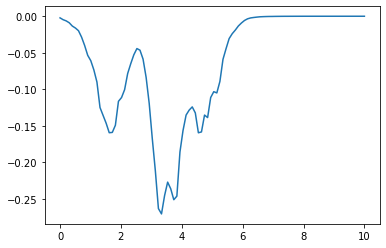

In [34]:
State.plot_wavefuction(epsilon_n, psi_gn, 0)

Energy: 0.4184957059621635


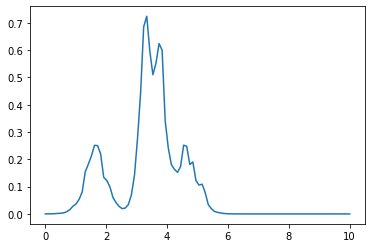

In [35]:
psi_gn = State.normalize(psi_gn)
State.plot_wavefuction(epsilon_n, psi_gn, 0)

In [24]:
print(State.integrate(psi_gn[0]))

1.0
